## 介绍



## 导入数据

第一步需要引入必要的包

In [28]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import jieba
import math
import os

%matplotlib inline

导入数据文件 `items.csv`, 并命名为`jobs`

In [6]:
file_path = './data'
abs_paths = [ os.path.abspath('./data/%s'% item) for item in os.listdir(file_path) if re.compile('.+\.csv$').match(item) ]
data_list = [ pd.read_csv(file_name) for file_name in abs_paths]


In [9]:
jobs  = pd.concat(data_list);jobs.head(5)

,address,comp_detail,comp_id,comp_name,comp_size,education,experience,job_desp,job_id,job_req,job_title,salary,salary_max,salary_min
0,公司地址：上海市长宁区金钟路968号凌空SOHO,NaN,https://www.liepin.com/company/182339/,携程,NaN,本科及以上,3年以上经验,职责描述：1、服务策略研发：不定期进行专题分析，包括对酒店群、用户群、酒店服务的分析等，研发...,https://www.liepin.com/job/1910030651.shtml,\n本科及以上 3年以上经验\n语言不限 年龄不限\n,大数据分析挖掘/机器学习工程师,23-38万,38.0,23.0
1,NaN,NaN,NaN,NaN,NaN,学历不限,3年以上经验,\n 岗位职责：1、分析和挖掘公司业务的优化机会，构建相应的数据...,https://www.liepin.com/a/9664206.shtml,\n学历不限\n3年以上经验\n语言不限\n23-40岁\n,数据分析挖掘师,90-120万,120.0,90.0
2,公司地址：上海市浦东新区博云路2号浦软大厦五楼东区,NaN,https://www.liepin.com/company/7867330/,钦文信息科技,NaN,统招本科,2年以上经验,职位描述1. 对用户行为进行建模，发现用户潜在意图和行为模式;2. 产品内关键算法设计，如推...,https://www.liepin.com/job/199173746.shtml,\n统招本科 2年以上经验\n普通话 年龄不限\n,数据分析工程师,面议,NaN,NaN
3,公司地址：上海浦东张江高科技园区碧波路690号2号楼201B,NaN,https://www.liepin.com/company/8057761/,侠特科技,NaN,本科及以上,3年以上经验,岗位职责：1、负责对公司所拥有的电商行业消费者大量数据进行建模和数据挖掘工作；2、负责公司E...,https://www.liepin.com/job/1910902659.shtml,\n本科及以上 3年以上经验\n语言不限 年龄不限\n,高级数据分析师,20-26万,26.0,20.0
4,NaN,NaN,NaN,NaN,NaN,统招本科,3年以上经验,\n 岗位描述1. 全面了解电商和互联网金融行业数据，通过大数据...,https://www.liepin.com/a/10128572.shtml,\n统招本科\n3年以上经验\n语言不限\n25-35岁\n,数据分析/挖掘/建模,60-90万,90.0,60.0


## 处理数据

按顺序保留如下列，存入新的变量`n_jobs`中：

```
['job_id', 'job_title','comp_name','salary','salary_min','salary_max','experience','job_desp','comp_id']

```

In [37]:
n_jobs = jobs[['job_id', 'job_title','comp_name','comp_size','address','salary_min','salary_max','experience','education','job_desp']]

接下来：
- 将`experience`需要的工作年限变为数值型
- 新增一列为平均工资，从最小和最大工资计算得出
- 分析下工作年限需要的分布
- 分析下工作年限跟薪水之间的关系
- 分析下工作职责描述中提到最多的技能项

In [38]:
def changeExp(x):
    pt_s = '(\d+)年以上经验'
    pt = re.compile(pt_s)
    if pt.match(x):
        gg = pt.search(x)
        return int(gg.group(1))
    elif x == '经验不限':
        return 0
    else:
        x = -1
        
n_jobs['experience'] = n_jobs['experience'].apply(changeExp);
n_jobs = n_jobs.set_index('job_id')
n_jobs.head(1)

/Users/fr4nk.yang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,job_title,comp_name,comp_size,address,salary_min,salary_max,experience,education,job_desp
job_id,,,,,,,,,
https://www.liepin.com/job/1910030651.shtml,大数据分析挖掘/机器学习工程师,携程,NaN,公司地址：上海市长宁区金钟路968号凌空SOHO,23.0,38.0,3.0,本科及以上,职责描述：1、服务策略研发：不定期进行专题分析，包括对酒店群、用户群、酒店服务的分析等，研发...


#### 计算平均工资

In [53]:
n_jobs['salary_avg'] = n_jobs[['salary_min', 'salary_max']].mean(axis=1)


### 从数据本身来看

使用 describe 函数，查看数据的大致情况。

首先分析，数据的类型，比如是离散or连续的，数值or字符型等等。

#### 数据基本情况

In [17]:
n_jobs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10428 entries, https://www.liepin.com/job/1910030651.shtml to https://www.liepin.com/a/9979176.shtml
Data columns (total 10 columns):
job_title     10428 non-null object
comp_name     3727 non-null object
comp_size     1157 non-null object
address       3727 non-null object
salary_min    9463 non-null float64
salary_max    9463 non-null float64
experience    7953 non-null float64
education     10428 non-null object
job_desp      10428 non-null object
salary_avg    9463 non-null float64
dtypes: float64(4), object(6)
memory usage: 896.2+ KB


可以得出一些初步事实：
- 数据有 10428 条
- 其中非猎头的职位信息有 3727 条, ~35%
- 给出具体薪资水平有 9463 条（~90%），其余是面谈
- 给出了经验要求有 7953 条（~76%）
- 全都给出了工作名称、学历和职责描述

In [18]:
n_jobs.describe(include=['O'])

,job_title,comp_name,comp_size,address,education,job_desp
count,10428,3727,1157,3727,10428,10428
unique,3819,849,8,1137,14,6260
top,算法工程师,美团点评,公司规模：100-499人,公司地址：上海市浦东新区金科路2889号 长泰广场C座 7楼,统招本科,职责描述：利用机器学习/深度学习的技术进行图像处理，语义理解，情感分析等的算法和系统研发；任...
freq,333,120,496,153,2753,21


得出一些初步结果：
- 算法工程师，也就是说做机器学习的title在公司中大多为算法工程师
- 发布工作最多的公司是 美团点评，有120条记录
- 其中公司规模，绝大多数为100-499人
- 对求职者学历要求，最常见的是统招本科

In [19]:
n_jobs.describe()

,salary_min,salary_max,experience,salary_avg
count,9463.000000,9463.000000,7953.000000,9463.000000
mean,36.317658,58.748283,3.316987,47.532971
std,25.545433,32.768015,1.840532,28.931213
min,3.000000,4.000000,0.000000,3.500000
25%,20.000000,39.000000,2.000000,30.000000
50%,30.000000,55.000000,3.000000,43.000000
75%,45.000000,70.000000,5.000000,55.000000
max,400.000000,460.000000,12.000000,430.000000


得出初步结论：
- 对机器学习、数据分析等方向的工作经验，平均要求是3.3年
- 薪水范围，最少的有10w, 50%起薪是30w
- 起薪范围最大值50%在55w

### 画图分析数据

#### 工作年限的需求分布

In [49]:
n_job_years = n_jobs['experience'].apply(lambda x: int(x) if not math.isnan(x) else -1)


Text(0,0.5,u'Count')

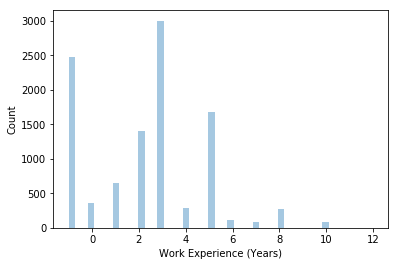

In [52]:
ax = sns.distplot(n_job_years, norm_hist=False, kde=False)
ax.set_xlabel('Work Experience (Years)')
ax.set_ylabel(u'Count')

#### 公司规模跟薪水的关系

In [57]:
comp_size_salary = n_jobs[['comp_size', 'salary_min', 'salary_max']].groupby('comp_size').mean().sort_values(by=['salary_min', 'salary_max'],ascending=True)

In [59]:
comp_size_salary

,salary_min,salary_max
comp_size,,
公司规模：1-49人,21.300000,37.750000
公司规模：500-999人,22.161616,41.070707
公司规模：2000-5000人,22.800000,39.066667
公司规模：1000-2000人,23.560000,41.280000
公司规模：100-499人,25.364486,43.548287
公司规模：10000人以上,26.459677,47.830645
公司规模：50-99人,26.910891,44.792079
公司规模：5000-10000人,30.200000,50.600000


In [74]:
def filter_nan(df):
    if df['comp_size'] is not None and df['salary_min'] is not None and df['salary_max'] is not None:
        return True
    else:
        return False
    
ss = n_jobs[['comp_size', 'salary_min', 'salary_max']].loc[filter_nan,:]; ss.head(5)
# gg = sns.FacetGrid(n_jobs, row="comp_size")
# gg = gg.map(plt.hist, ['salary_min', 'salary_max'])

KeyError: 'the label [True] is not in the [index]'

工作年限跟薪水的关系

In [33]:
salary_exp = n_jobs.groupby('experience').mean().reset_index()

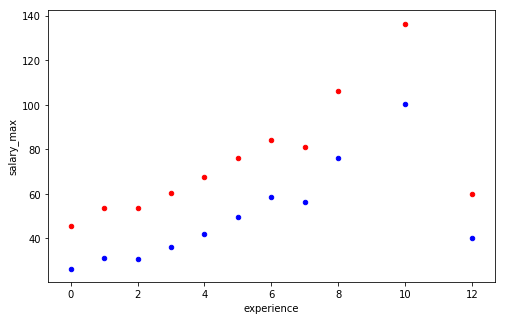

In [34]:
ax = salary_exp.plot( kind='scatter',x='experience',   y='salary_min', color='b', figsize=(8,5) )
salary_exp.plot(kind='scatter',x='experience',  y='salary_max', color='r', ax = ax)

plt.show()
